In [3]:
#set up notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

admissions = pd.read_csv('ADMISSIONS.csv')

In [4]:
admissions.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [5]:
admissions.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
       'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA'],
      dtype='object')

In [6]:
admissions.groupby(['ADMISSION_TYPE']).size()

ADMISSION_TYPE
ELECTIVE      7706
EMERGENCY    42071
NEWBORN       7863
URGENT        1336
dtype: int64

**CONVERT STRINGS TO DATES**

A note about dates from MIMIC website: All dates in the database have been shifted to protect patient confidentiality. Dates will be internally consistent for the same patient, but randomly distributed in the future.

In [7]:
#convert to dates:
admissions.ADMITTIME = pd.to_datetime(admissions.ADMITTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
admissions.DISCHTIME = pd.to_datetime(admissions.DISCHTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
admissions.DEATHTIME = pd.to_datetime(admissions.DEATHTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')

# check to see if there are any missing dates
print('Number of missing date admissions:', admissions.ADMITTIME.isnull().sum())
print('Number of missing date discharges:', admissions.DISCHTIME.isnull().sum())

Number of missing date admissions: 0
Number of missing date discharges: 0


**GET THE NEXT ADMISSION DATE IF IT EXISTS:**

In this project, we need the next admission date if it exists. We can get this with the shift() function, but we need to verify the dates are in order.

In [8]:
#sort by subject_ID and admission date
admissions = admissions.sort_values(['SUBJECT_ID', 'ADMITTIME'])
admissions = admissions.reset_index(drop = True)

In [9]:
# verify that it did what we wanted
admissions.loc[admissions.SUBJECT_ID == 124,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE']]

,SUBJECT_ID,ADMITTIME,ADMISSION_TYPE
165,124,2160-06-24 21:25:00,EMERGENCY
166,124,2161-12-17 03:39:00,EMERGENCY
167,124,2165-05-21 21:02:00,ELECTIVE
168,124,2165-12-31 18:55:00,EMERGENCY


In [10]:
# add the next admission date and type for each subject using groupby
# you have to use groupby otherwise the dates will be different from subjects
admissions['NEXT_ADMITTIME'] = admissions.groupby('SUBJECT_ID').ADMITTIME.shift(-1)

# get the next admission type
admissions['NEXT_ADMISSION_TYPE'] = admissions.groupby('SUBJECT_ID').ADMISSION_TYPE.shift(-1)

In [11]:
# verify that it did what we wanted
admissions.loc[admissions.SUBJECT_ID == 124,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE','NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']]

,SUBJECT_ID,ADMITTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE
165,124,2160-06-24 21:25:00,EMERGENCY,2161-12-17 03:39:00,EMERGENCY
166,124,2161-12-17 03:39:00,EMERGENCY,2165-05-21 21:02:00,ELECTIVE
167,124,2165-05-21 21:02:00,ELECTIVE,2165-12-31 18:55:00,EMERGENCY
168,124,2165-12-31 18:55:00,EMERGENCY,NaT,NaN


But we need to filter out the ELECTIVE next admissions because we want to predict UNPLANNED re-admissions

In [12]:
rows = admissions.NEXT_ADMISSION_TYPE == 'ELECTIVE'
admissions.loc[rows,'NEXT_ADMITTIME'] = pd.NaT
admissions.loc[rows,'NEXT_ADMISSION_TYPE'] = np.NaN

In [13]:
# verify that it did what we wanted
admissions.loc[admissions.SUBJECT_ID == 124,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE','NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']]

,SUBJECT_ID,ADMITTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE
165,124,2160-06-24 21:25:00,EMERGENCY,2161-12-17 03:39:00,EMERGENCY
166,124,2161-12-17 03:39:00,EMERGENCY,NaT,NaN
167,124,2165-05-21 21:02:00,ELECTIVE,2165-12-31 18:55:00,EMERGENCY
168,124,2165-12-31 18:55:00,EMERGENCY,NaT,NaN


In [14]:
# sort by subject_ID and admission date
# it is safer to sort right before the fill incase something changed the order above
admissions = admissions.sort_values(['SUBJECT_ID','ADMITTIME'])

# back fill (this will take a little while)
admissions[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']] = admissions.groupby(['SUBJECT_ID'])[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']].fillna(method = 'bfill')

In [15]:
# verify that it did what we wanted
admissions.loc[admissions.SUBJECT_ID == 124,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE','NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']]

,SUBJECT_ID,ADMITTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE
165,124,2160-06-24 21:25:00,EMERGENCY,2161-12-17 03:39:00,EMERGENCY
166,124,2161-12-17 03:39:00,EMERGENCY,2165-12-31 18:55:00,EMERGENCY
167,124,2165-05-21 21:02:00,ELECTIVE,2165-12-31 18:55:00,EMERGENCY
168,124,2165-12-31 18:55:00,EMERGENCY,NaT,NaN


CALCULATE DAYS UNTIL NEXT ADMISSION

In [16]:
# calculate the number of days between discharge and next admission
admissions['DAYS_NEXT_ADMIT']=  (admissions.NEXT_ADMITTIME - admissions.DISCHTIME).dt.total_seconds()/(24*60*60)

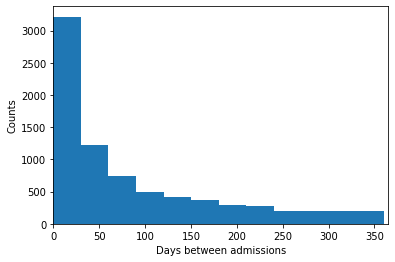

In [17]:
# plot a histogram of days between readmissions if they exist
# this only works for non-null values so you have to filter
plt.hist(admissions.loc[~admissions.DAYS_NEXT_ADMIT.isnull(),'DAYS_NEXT_ADMIT'], bins =range(0,365,30))
plt.xlim([0,365])
plt.xlabel('Days between admissions')
plt.ylabel('Counts')
plt.show()

In [18]:
print('Cases with a readmission:', (~admissions.DAYS_NEXT_ADMIT.isnull()).sum())
print('Total cases:', len(admissions))

Cases with a readmission: 11399
Total cases: 58976


**LOAD THE NOTES**

In [19]:
notes = pd.read_csv("NOTEEVENTS.csv")

C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [20]:
print('Number of admission', len(admissions))
print('Number of notes:',len(notes))

Number of admission 58976
Number of notes: 2083180


The number of notes is bigger than the number of admissions because there can be multiple notes

In [21]:
notes.CATEGORY.unique()

array(['Discharge summary', 'Echo', 'ECG', 'Nursing', 'Physician ',
       'Rehab Services', 'Case Management ', 'Respiratory ', 'Nutrition',
       'General', 'Social Work', 'Pharmacy', 'Consult', 'Radiology',
       'Nursing/other'], dtype=object)

In [22]:
notes.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853.0,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527.0,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118.0,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...
3,177,13702,196489.0,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...
4,178,26880,135453.0,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...


In [23]:
# look at the first note
notes.TEXT.iloc[0]


'Admission Date:  [**2151-7-16**]       Discharge Date:  [**2151-8-4**]\n\n\nService:\nADDENDUM:\n\nRADIOLOGIC STUDIES:  Radiologic studies also included a chest\nCT, which confirmed cavitary lesions in the left lung apex\nconsistent with infectious process/tuberculosis.  This also\nmoderate-sized left pleural effusion.\n\nHEAD CT:  Head CT showed no intracranial hemorrhage or mass\neffect, but old infarction consistent with past medical\nhistory.\n\nABDOMINAL CT:  Abdominal CT showed lesions of\nT10 and sacrum most likely secondary to osteoporosis. These can\nbe followed by repeat imaging as an outpatient.\n\n\n\n                            [**First Name8 (NamePattern2) **] [**First Name4 (NamePattern1) 1775**] [**Last Name (NamePattern1) **], M.D.  [**MD Number(1) 1776**]\n\nDictated By:[**Hospital 1807**]\nMEDQUIST36\n\nD:  [**2151-8-5**]  12:11\nT:  [**2151-8-5**]  12:21\nJOB#:  [**Job Number 1808**]\n'

We can see that the dates and PHI have been converted for confidentiality. There are '\n' characters, numbers and punctuation.

At this point, we have to make a choice on what notes to use. For simplicity, let's use the discharge summary, but we could use all the notes by concatenating them.

In [24]:
# filter to discharge summary
notes_dis_sum = notes.loc[notes.CATEGORY == 'Discharge summary']

In [25]:
notes_dis_sum.TEXT.iloc[0]

'Admission Date:  [**2151-7-16**]       Discharge Date:  [**2151-8-4**]\n\n\nService:\nADDENDUM:\n\nRADIOLOGIC STUDIES:  Radiologic studies also included a chest\nCT, which confirmed cavitary lesions in the left lung apex\nconsistent with infectious process/tuberculosis.  This also\nmoderate-sized left pleural effusion.\n\nHEAD CT:  Head CT showed no intracranial hemorrhage or mass\neffect, but old infarction consistent with past medical\nhistory.\n\nABDOMINAL CT:  Abdominal CT showed lesions of\nT10 and sacrum most likely secondary to osteoporosis. These can\nbe followed by repeat imaging as an outpatient.\n\n\n\n                            [**First Name8 (NamePattern2) **] [**First Name4 (NamePattern1) 1775**] [**Last Name (NamePattern1) **], M.D.  [**MD Number(1) 1776**]\n\nDictated By:[**Hospital 1807**]\nMEDQUIST36\n\nD:  [**2151-8-5**]  12:11\nT:  [**2151-8-5**]  12:21\nJOB#:  [**Job Number 1808**]\n'

In [26]:
notes_dis_sum_last = (notes_dis_sum.groupby(['SUBJECT_ID','HADM_ID']).nth(-1)).reset_index()
assert notes_dis_sum_last.duplicated(['HADM_ID']).sum() == 0, 'Multiple discharge summaries per admission'

**Merge data sets**

In [27]:
adm_notes = pd.merge(admissions[['SUBJECT_ID','HADM_ID','ADMITTIME','DISCHTIME','DAYS_NEXT_ADMIT','NEXT_ADMITTIME','ADMISSION_TYPE','DEATHTIME']],
                        notes_dis_sum_last[['SUBJECT_ID','HADM_ID','TEXT']], 
                        on = ['SUBJECT_ID','HADM_ID'],
                        how = 'left')
assert len(admissions) == len(adm_notes), 'Number of rows increased'

Check to see if there a re alot of notes that are missing text (might be a sign of a problem).

In [28]:
print('Fraction of missing notes:', adm_notes.TEXT.isnull().sum() / len(adm_notes))
print('Fraction notes with newlines:', adm_notes.TEXT.str.contains('\n').sum() / len(adm_notes))

Fraction of missing notes: 0.1059753119913185
Fraction notes with newlines: 0.8940246880086815


In [29]:
adm_notes.groupby('ADMISSION_TYPE').apply(lambda g: g.TEXT.isnull().sum())/adm_notes.groupby('ADMISSION_TYPE').size()

ADMISSION_TYPE
ELECTIVE     0.048663
EMERGENCY    0.037983
NEWBORN      0.536691
URGENT       0.042665
dtype: float64

Remove NEWBORN

In [30]:
adm_notes_clean = adm_notes.loc[adm_notes.ADMISSION_TYPE != 'NEWBORN'].copy()

In [31]:
print('Fraction of missing notes:', adm_notes_clean.TEXT.isnull().sum() / len(adm_notes_clean))
print('Fraction notes with newlines:', adm_notes_clean.TEXT.str.contains('\n').sum() / len(adm_notes_clean))
print('Fraction notes with carriage returns:', adm_notes_clean.TEXT.str.contains('\r').sum() / len(adm_notes_clean))

Fraction of missing notes: 0.03971592354195606
Fraction notes with newlines: 0.9602840764580439
Fraction notes with carriage returns: 0.0


Additional analysis might be required to see if there are any specific cases why a discharge would not appear. For now, we will push forward.

**Prepare a label**

I like to create a specific column in the dataframe as OUTPUT_LABEL that has exactly what we are trying to predict. Here we want if the patient was re-admitted within 30 days

In [32]:
adm_notes_clean['OUTPUT_LABEL'] = (adm_notes_clean.DAYS_NEXT_ADMIT < 30).astype('int')

In [33]:
print('Number of positive samples:', (adm_notes_clean.OUTPUT_LABEL == 1).sum())
print('Number of negative samples:',  (adm_notes_clean.OUTPUT_LABEL == 0).sum())
print('Total samples:', len(adm_notes_clean))

Number of positive samples: 3004
Number of negative samples: 48109
Total samples: 51113


**Create training and test dataframes**

In [34]:
#shuffle the samples
adm_notes_clean = adm_notes_clean.sample(n = len(adm_notes_clean), random_state = 42)
adm_notes_clean = adm_notes_clean.reset_index(drop = True)

valid_test = adm_notes_clean.sample(frac = 0.3, random_state = 42)
test = valid_test.sample(frac = 0.5, random_state = 42)
valid = valid_test.drop(test.index)

#use the rest of the data as training data
train = adm_notes_clean.drop(valid_test.index)

print('Test prevalence(n = %d):'%len(test), test.OUTPUT_LABEL.sum()/ len(test))
print('Valid prevalence(n = %d):'%len(valid), valid.OUTPUT_LABEL.sum()/ len(valid))
print('Train prevalence(n = %d):'%len(train), train.OUTPUT_LABEL.sum()/ len(train))
print('all samples (n = %d)'%len(adm_notes_clean))
assert len(adm_notes_clean) == (len(test)+len(valid)+len(train)),'math didnt work'

Test prevalence(n = 7667): 0.061953828094430674
Valid prevalence(n = 7667): 0.056997521846876224
Train prevalence(n = 35779): 0.05847005226529529
all samples (n = 51113)


Since the prevalence is so low, we want to prevent the model from always predicting negative. To do this, we have a few options

- Balance the data by sub-sampling the negatives
- Balance the data by over-sampling the positives
- Create synthetic data (e.g. SMOTE)

In this example, we will sub-sample the negatives

In [35]:
# split the training data into positive and negative
rows_pos = train.OUTPUT_LABEL == 1
train_pos = train.loc[rows_pos]
train_neg = train.loc[~rows_pos]

#merge the balanced data
train = pd.concat([train_pos, train_neg.sample(n = len(train_pos), random_state = 42)], axis = 0)

#shuffle the order of training samples
train = train.sample(n = len(train), random_state = 42).reset_index(drop = True)

print('Train prevalence (n = %d):'%len(train), train.OUTPUT_LABEL.sum()/ len(train))

Train prevalence (n = 4184): 0.5


# Step 2: Preprocess text data

Now that we have created data sets that have a label and the notes, we need to preprocess our text data to convert it to something useful (i.e. numbers) for the machine learning model. We are going to use the Bag-of-Words (BOW) approach.

BOW basically breaks up the note into the individual words and counts how many times each word occurs. Your numerical data then becomes counts for some set of words as shown below. BOW is the simplest way to do NLP classification. In most blog posts I have read, fancier techniques have a hard time beating BOW for NLP classification tasks.

In this process, there are few choices that need to be made:

- how to pre-process the words
- how to count the words
- which words to use


**Preprocess all the notes**

Modify the original dataframe by dealing with the missing text, newlines and carriage returns

In [36]:
def preprocess_text(df):
    df.TEXT = df.TEXT.fillna(' ')
    df.TEXT =df.TEXT.str.replace('\n',' ')
    df.TEXT =df.TEXT.str.replace('\r',' ')
    return df

In [37]:
# preprocess the text to deal with known issues
df_train = preprocess_text(train)
df_valid = preprocess_text(valid)
df_test = preprocess_text(test)

**Build a tokenizer**

Now we need to create a function that splits the note into individual words. This function is called a tokenizer. We can use the nltk.word_tokenize function to this for us.

In [38]:
import nltk
from nltk import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

We can define our own custom tokenizer. Our tokenizer will:

- Replace punctuation with spaces
- Remove numbers with spaces
- Lowercase all words

In [39]:
import string
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [40]:
def tokenizer_better(text):
    # tokenize the text by replacing punctuation and numbers with spaces and lowercase all words
    punc_list = string.punctuation+'0123456789'
    t = str.maketrans(dict.fromkeys(punc_list, " "))
    text = text.lower().translate(t)
    tokens = word_tokenize(text)
    return tokens

In [41]:
tokenizer_better('This should be tokenized. 02/02/2018 sentence has stars**')

['this', 'should', 'be', 'tokenized', 'sentence', 'has', 'stars']

**Build a simple vectorizer**

Now that we have a way to convert free-text into tokens, we need a way to create features from these tokens.

In [42]:
sample_text = ['Data science is about the data', 'The science is amazing', 'Predictive modeling is part of data science']

In [43]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(tokenizer = tokenizer_better)
vect.fit(sample_text)

# matrix is stored as a sparse matrix (since you have a lot of zeros)
X = vect.transform(sample_text)

C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [45]:
X.toarray()

array([[1, 0, 2, 1, 0, 0, 0, 0, 1, 1],
       [0, 1, 0, 1, 0, 0, 0, 0, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 0]], dtype=int64)

In [46]:
vect.get_feature_names()

C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['about',
 'amazing',
 'data',
 'is',
 'modeling',
 'of',
 'part',
 'predictive',
 'science',
 'the']

# **Build a vectorizer on the clinical notes**

In [47]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(max_features = 3000, tokenizer = tokenizer_better)

vect.fit(train.TEXT.values)

C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CountVectorizer(max_features=3000,
                tokenizer=<function tokenizer_better at 0x000001D170EB80D0>)

# **Zipf's law**

C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


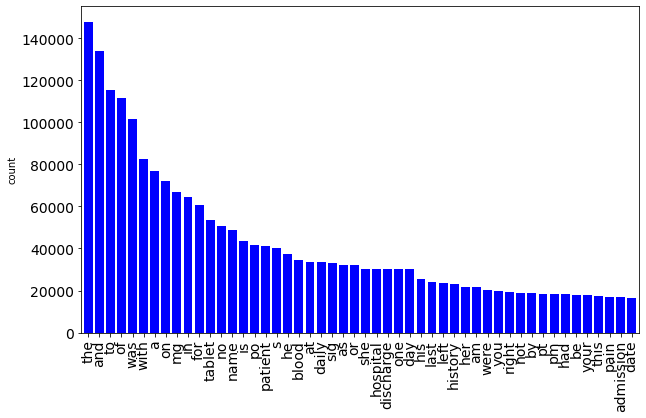

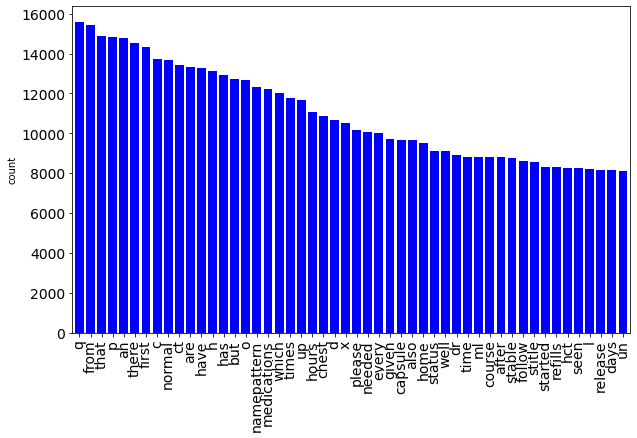

In [48]:
neg_doc_matrix = vect.transform(train[train.OUTPUT_LABEL == 0].TEXT)
pos_doc_matrix = vect.transform(train[train.OUTPUT_LABEL == 1].TEXT)
neg_tf = np.sum(neg_doc_matrix, axis = 0)
pos_tf = np.sum(pos_doc_matrix, axis = 0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))

term_freq = pd.DataFrame([neg, pos], columns = vect.get_feature_names()).transpose()
term_freq.columns = ['negative', 'positive']
term_freq['total'] = term_freq['negative'] + term_freq['positive']
term_freq.sort_values(by='total', ascending=False).iloc[:10]

#Create a series from the sparse matrix
d = pd.Series(term_freq.total, index = term_freq.index).sort_values(ascending = False)
ax = d[:50].plot(kind = 'bar', figsize = (10,6), width = .8, fontsize = 14, rot = 90, color = 'b')
ax.title.set_size(18)
plt.ylabel('count')
plt.show()
ax = d[50:100].plot(kind='bar', figsize=(10,6), width=.8, fontsize=14, rot=90,color = 'b')
ax.title.set_size(18)
plt.ylabel('count')
plt.show()

In [49]:
my_stop_words = ['the','and','to','of','was','with','a','on','in','for','name',
                 'is','patient','s','he','at','as','or','one','she','his','her','am',
                 'were','you','pt','pm','by','be','had','your','this','date',
                'from','there','an','that','p','are','have','has','h','but','o',
                'namepattern','which','every','also']

In [50]:
vect = CountVectorizer(max_features = 3000, 
                       tokenizer = tokenizer_better, 
                       stop_words = my_stop_words)
# this could take a while
vect.fit(df_train.TEXT.values)

C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CountVectorizer(max_features=3000,
                stop_words=['the', 'and', 'to', 'of', 'was', 'with', 'a', 'on',
                            'in', 'for', 'name', 'is', 'patient', 's', 'he',
                            'at', 'as', 'or', 'one', 'she', 'his', 'her', 'am',
                            'were', 'you', 'pt', 'pm', 'by', 'be', 'had', ...],
                tokenizer=<function tokenizer_better at 0x000001D170EB80D0>)

Transform notes into the vector format

In [51]:
X_train_tf = vect.transform(df_train.TEXT.values)
X_valid_tf = vect.transform(df_valid.TEXT.values)

In [52]:
y_train = df_train.OUTPUT_LABEL
y_valid = df_valid.OUTPUT_LABEL

# **Step 3: Build a simple predictive model**

Use logistic regression from scikit-learn

In [53]:
from sklearn.linear_model import LogisticRegression
clf=LogisticRegression(C = 0.0001, penalty = 'l2', random_state = 42)
clf.fit(X_train_tf, y_train)

LogisticRegression(C=0.0001, random_state=42)

Calculate probability of re-admission

In [54]:
model = clf
y_train_preds = model.predict_proba(X_train_tf)[:,1]
y_valid_preds = model.predict_proba(X_valid_tf)[:,1]

print(y_train[:10].values)
print(y_train_preds[:10])

[1 1 0 1 1 1 0 0 1 1]
[0.42013987 0.4360379  0.28809073 0.6238073  0.24422986 0.45490439
 0.33683096 0.91645687 0.69387608 0.50733574]


In [56]:
def calc_accuracy(y_actual, y_pred, thresh):
    # this function calculates the accuracy with probability threshold at thresh
    return (sum((y_pred > thresh) & (y_actual == 1))+sum((y_pred < thresh) & (y_actual == 0))) /len(y_actual)

def calc_recall(y_actual, y_pred, thresh):
    # calculates the recall
    return sum((y_pred > thresh) & (y_actual == 1)) /sum(y_actual)

def calc_precision(y_actual, y_pred, thresh):
    # calculates the precision
    return sum((y_pred > thresh) & (y_actual == 1)) /sum(y_pred > thresh)

def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def calc_prevalence(y_actual):
    # calculates prevalence
    return sum((y_actual == 1)) /len(y_actual)

Train AUC:0.754
Valid AUC:0.706
Train accuracy:0.685
Valid accuracy:0.714
Train recall:0.624
Valid recall:0.595
Train recall:0.624
Valid recall:0.595
Train precision:0.712
Valid precision:0.114
Train specificity:0.747
Valid specificity:0.721
Train prevalence:0.500
Valid prevalence:0.057


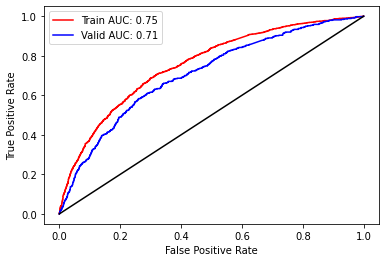

In [57]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)


thresh = 0.5

auc_train = roc_auc_score(y_train, y_train_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

print('Train AUC:%.3f'%auc_train)
print('Valid AUC:%.3f'%auc_valid)

print('Train accuracy:%.3f'%calc_accuracy(y_train, y_train_preds, thresh))
print('Valid accuracy:%.3f'%calc_accuracy(y_valid, y_valid_preds, thresh))


print('Train recall:%.3f'%calc_recall(y_train, y_train_preds, thresh))
print('Valid recall:%.3f'%calc_recall(y_valid, y_valid_preds, thresh))

print('Train recall:%.3f'%calc_recall(y_train, y_train_preds, thresh))
print('Valid recall:%.3f'%calc_recall(y_valid, y_valid_preds, thresh))

print('Train precision:%.3f'%calc_precision(y_train, y_train_preds, thresh))
print('Valid precision:%.3f'%calc_precision(y_valid, y_valid_preds, thresh))

print('Train specificity:%.3f'%calc_specificity(y_train, y_train_preds, thresh))
print('Valid specificity:%.3f'%calc_specificity(y_valid, y_valid_preds, thresh))

print('Train prevalence:%.3f'%calc_prevalence(y_train))
print('Valid prevalence:%.3f'%calc_prevalence(y_valid))


plt.plot(fpr_train, tpr_train,'r-', label = 'Train AUC: %.2f'%auc_train)
plt.plot(fpr_valid, tpr_valid,'b-',label = 'Valid AUC: %.2f'%auc_valid)
plt.plot([0,1],[0,1],'-k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()